In [1]:
import pandas as pd
import numpy as np
import chardet
import matplotlib.pyplot as plt
from scipy import stats
import math
from pathlib import Path
from os.path import basename, dirname, isdir, isfile, join
from matplotlib.widgets import Slider
import mpldatacursor
from matplotlib import rcParams
from scipy.signal import savgol_filter, butter, filtfilt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


### TU Delft Color Scheme

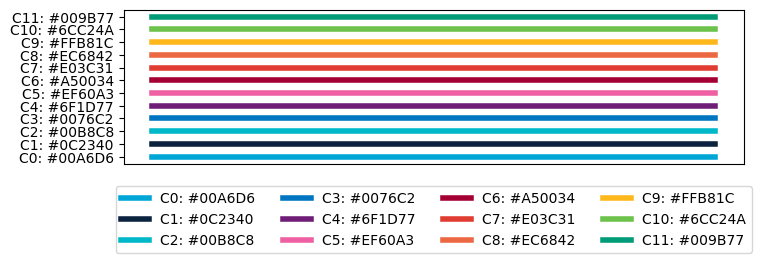

In [2]:
# Define the custom color scheme
custom_colors = [
    "#00A6D6", "#0C2340", "#00B8C8", "#0076C2",
    "#6F1D77", "#EF60A3", "#A50034", "#E03C31",
    "#EC6842", "#FFB81C", "#6CC24A", "#009B77"
]

# Set the color cycle to the custom colors
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)

# Plot a sample to display the colors
fig, ax = plt.subplots(figsize=(8, 2))

for idx, color in enumerate(custom_colors):
    ax.plot([0, 1], [idx, idx], lw=4, color=color, label=f'C{idx}: {color}')

ax.set_yticks(range(len(custom_colors)))
ax.set_yticklabels([f'C{idx}: {color}' for idx, color in enumerate(custom_colors)])
ax.set_xticks([])

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4)
plt.show()


## Load and Display Data

### Define the File Paths
Set the file paths for the water level CSV and weather station Excel files.

### Load the Water Level Data
Read the CSV file into a DataFrame `WL`, parsing dates correctly and setting the first column as the index.

### Load the Weather Station Data
Read the Excel file into a DataFrame `WS`, skipping the first row and parsing dates correctly.

In [3]:
# Define the file paths
Water_level_path = "Water_level_bioswale_AdeKUS.csv"
xlsx_file_path = "Hydrometcloud_data_Ringharbour.xlsx"

# Read the CSV file into a DataFrame WaterLevel (WL)
WL = pd.read_csv(Water_level_path, sep=';', parse_dates=[0], dayfirst=True, index_col=0)

# Read the Excel file into a DataFrame WeatherStation (WS)
WS = pd.read_excel(xlsx_file_path, index_col=[0], parse_dates=True)

# Display the head of each DataFrame
# print("WaterLevel DataFrame (WL):")
# print(WL.describe())

# print("\nWeatherStation DataFrame (WS):")
# print(WS.describe())

### Resample Weather Station Data
Resample the weather station DataFrame (`WS`) to a daily frequency and calculate the daily mean values.

```python
WS_daily_mean = WS.resample('D').mean()


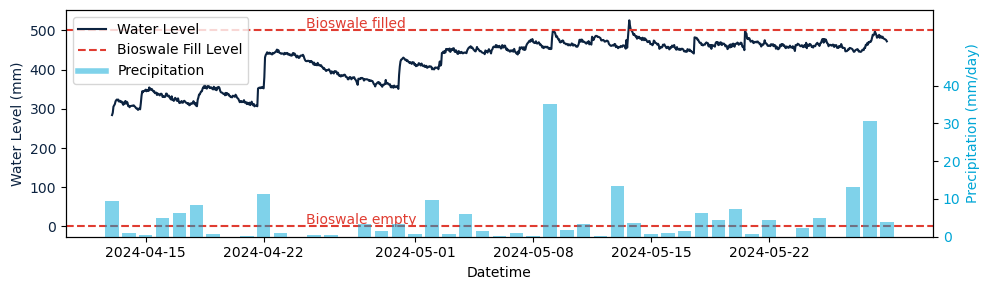

In [4]:
# Resample entire weather station DataFrame to daily and calculate mean
WS_daily_mean = WS.resample('D').mean()

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 3))

# Create a secondary y-axis for daily rain
ax2 = ax1.twinx()
bar_container = ax2.bar(WS_daily_mean.index, WS_daily_mean['Daily Rain(mm)'], color='C0', alpha=0.5, label='Precipitation')
ax2.set_ylabel('Precipitation (mm/day)', color='C0')
ax2.tick_params(axis='y', labelcolor='C0')
precipitation_ticks = [0, 10, 20, 30, 40]
ax2.set_yticks(precipitation_ticks)
ax2.set_ylim(0, 60)

# Plot water level
line1, = ax1.plot(WL.index, WL['Water_level_diver(mm)'], color='C1', label='Water Level')
ax1.set_ylabel('Water Level (mm)', color='C1')
ax1.tick_params(axis='y', labelcolor='C1')

# Add horizontal lines at y = 500 and y = 0
ax1.axhline(y=500, color='C7', linestyle='--')
ax1.text(WL.index[len(WL)//4], 505, 'Bioswale filled', color='C7')  # Adjusted position
ax1.axhline(y=0, color='C7', linestyle='--', label='Bioswale Fill Level')
ax1.text(WL.index[len(WL)//4], 5, 'Bioswale empty', color='C7')  # Adjusted position

# Add label for x-axis
ax1.set_xlabel('Datetime')

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = bar_container.get_children(), [bar_container.get_label()]
ax2_legend = [plt.Line2D([0], [0], color='C0', lw=4, alpha=0.5)]

lines += ax2_legend
labels += labels2

ax1.legend(lines, labels, loc='upper left')

# Show plot
plt.tight_layout()

# Save the plot with grid
plt.grid(True)
plt.savefig('Figures/BS_AdeKUS_grid.png')

# Save the plot without grid
plt.grid(False)
plt.savefig('Figures/BS_AdeKUS_nogrid.png')

# Show plot
plt.show()

### Figure Description

In the figure, we can observe that the bioswale is predominantly filled, suggesting effective water retention. There are discernible responses to rainfall events, evident from fluctuations in water levels, indicating successful infiltration, but because the water levels remain high infiltration seems limited. Notably, around May 15th, there is evidence of a flood event where the water level surpasses the depth of the bioswale, potentially highlighting its capacity limits under extreme conditions.

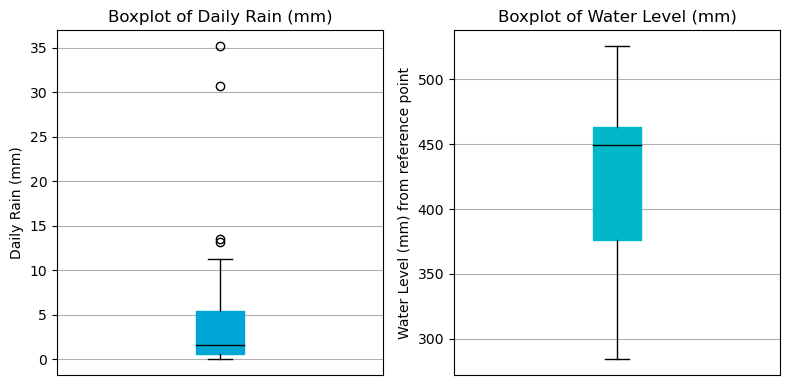

In [5]:
# Create a new figure for the boxplots
fig, (ax_box1, ax_box2) = plt.subplots(1, 2, figsize=(8, 4))

# Plot boxplot of daily rain
ax_box1.boxplot(WS_daily_mean['Daily Rain(mm)'], patch_artist=True, 
                boxprops=dict(facecolor='C0', color='C0'), medianprops=dict(color='black'))
ax_box1.set_title('Boxplot of Daily Rain (mm)')
ax_box1.set_ylabel('Daily Rain (mm)')
ax_box1.grid(True)

# Plot boxplot of water level
ax_box2.boxplot(WL['Water_level_diver(mm)'], patch_artist=True, 
                boxprops=dict(facecolor='C2', color='C2'), medianprops=dict(color='black'))
ax_box2.set_title('Boxplot of Water Level (mm)')
ax_box2.set_ylabel('Water Level (mm) from reference point')
ax_box2.grid(True)

# Remove x-axis labels and ticks
ax_box1.xaxis.set_visible(False)
ax_box2.xaxis.set_visible(False)

# Adjust layout
plt.tight_layout()

# Save the plots
plt.savefig('Figures/WS_WL_boxplots.png')

# Show plot
plt.show()


### Moving Average Filter
Applies a moving average filter with a window size of 7 days. This filter smooths the data by averaging over a specified number of previous points:
$$ MA_t = \frac{1}{N} \sum_{i=0}^{N-1} x_{t-i} $$

### Savitzky-Golay Filter
Applies a Savitzky-Golay filter with a window length of 11 and polynomial order of 2. This filter smooths the data by fitting successive sub-sets of adjacent data points with a low-degree polynomial by the method of linear least squares:
$$ y_i = \sum_{k=-m}^{m} c_k x_{i+k} $$
where $c_k$ are the filter coefficients obtained by polynomial fitting.

### Low-Pass Filter
Applies a Butterworth low-pass filter with a cutoff frequency of 0.1. The filter passes signals with a frequency lower than the cutoff and attenuates signals with frequencies higher than the cutoff:
$$ H(s) = \frac{1}{\sqrt{1 + \left(\frac{s}{\omega_c}\right)^{2n}}} $$
where $\omega_c$ is the cutoff frequency and $n$ is the order of the filter.

### Kalman Filter
Uses a Kalman filter for noise reduction. The Kalman filter operates recursively on streams of noisy input data to produce statistically optimal estimates of the underlying system state. The Kalman filter equations are:

**Time Update (Predict)**
$$ \hat{x}_{k|k-1} = \hat{x}_{k-1|k-1} $$
$$ P_{k|k-1} = P_{k-1|k-1} + Q $$

**Measurement Update (Correct)**
$$ K_k = \frac{P_{k|k-1}}{P_{k|k-1} + R} $$
$$ \hat{x}_{k|k} = \hat{x}_{k|k-1} + K_k(z_k - \hat{x}_{k|k-1}) $$
$$ P_{k|k} = (1 - K_k)P_{k|k-1} $$


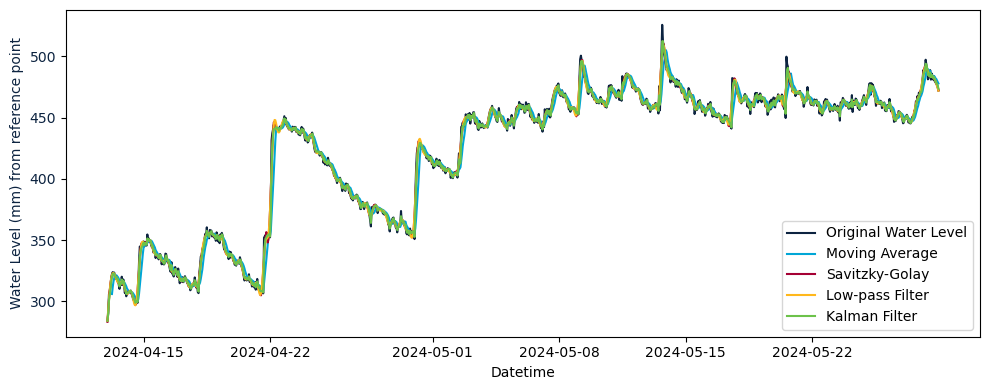

In [6]:
# Extract the water level data
water_level = WL['Water_level_diver(mm)']

# Moving average filter
window_size = 7
moving_average = water_level.rolling(window=window_size).mean()


# Savitzky-Golay filter
savgol_filtered = savgol_filter(water_level, window_length=11, polyorder=2)

# Low-pass filter
def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def lowpass_filter(data, cutoff=0.1, fs=1.0, order=5):
    b, a = butter_lowpass(cutoff, fs, order)
    y = filtfilt(b, a, data)
    return y

lowpass_filtered = lowpass_filter(water_level, cutoff=0.1)

# Kalman filter
def kalman_filter(data):
    n_iter = len(data)
    sz = (n_iter,) # size of array
    xhat = np.zeros(sz)      # a posteri estimate of x
    P = np.zeros(sz)         # a posteri error estimate
    xhatminus = np.zeros(sz) # a priori estimate of x
    Pminus = np.zeros(sz)    # a priori error estimate
    K = np.zeros(sz)         # gain or blending factor

    Q = 1e-2 # process variance
    R = 0.1**2 # estimate of measurement variance, change to see effect

    # initial guesses
    xhat[0] = data[0]
    P[0] = 1.0

    for k in range(1,n_iter):
        # time update
        xhatminus[k] = xhat[k-1]
        Pminus[k] = P[k-1]+Q

        # measurement update
        K[k] = Pminus[k]/(Pminus[k]+R)
        xhat[k] = xhatminus[k]+K[k]*(data[k]-xhatminus[k])
        P[k] = (1-K[k])*Pminus[k]

    return xhat

kalman_filtered = kalman_filter(water_level.values)

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 4))

ax1.plot(WL.index, WL['Water_level_diver(mm)'], color='C1', label='Original Water Level')
ax1.plot(WL.index, moving_average, color='C0', label='Moving Average')
ax1.plot(WL.index, savgol_filtered, color='C6', label='Savitzky-Golay')
ax1.plot(WL.index, lowpass_filtered, color='C9', label='Low-pass Filter')
ax1.plot(WL.index, kalman_filtered, color='C10', label='Kalman Filter')

# Add label for x-axis
ax1.set_xlabel('Datetime')
ax1.set_ylabel('Water Level (mm) from reference point', color='C1')
ax1.tick_params(axis='y', labelcolor='C1')

# Combine legends
ax1.legend(loc='lower right')

# Show plot
plt.tight_layout()
plt.savefig('Figures/Filtered_Water_Level.png')
plt.show()


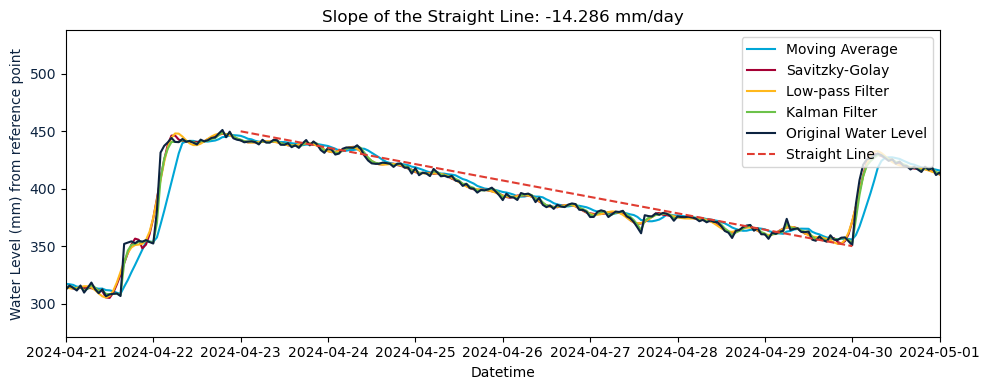

In [7]:
# Plotting
fig, ax1 = plt.subplots(figsize=(10, 4))

# Plot original water level and filters
ax1.plot(WL.index, moving_average, color='C0', label='Moving Average')
ax1.plot(WL.index, savgol_filtered, color='C6', label='Savitzky-Golay')
ax1.plot(WL.index, lowpass_filtered, color='C9', label='Low-pass Filter')
ax1.plot(WL.index, kalman_filtered, color='C10', label='Kalman Filter')
ax1.plot(WL.index, WL['Water_level_diver(mm)'], color='C1', label='Original Water Level')

# Define the points for the straight line
x1 = pd.Timestamp('2024-04-23')
y1 = 450
x2 = pd.Timestamp('2024-04-30')
y2 = 350

# Draw a straight line from [x=2024-04-23, y=450] to [x=2024-04-30, y=350]
ax1.plot([x1, x2], [y1, y2], color='C7', linestyle='--', label='Straight Line')

# Calculate the slope of the straight line
slope = (y2 - y1) / (x2 - x1).days

# Set the title with the slope information
ax1.set_title(f'Slope of the Straight Line: {slope:.3f} mm/day')

# Add label for x-axis
ax1.set_xlabel('Datetime')
ax1.set_ylabel('Water Level (mm) from reference point', color='C1')
ax1.tick_params(axis='y', labelcolor='C1')

# Combine legends
ax1.legend(loc='upper right')

# Set the x-axis limits to zoom in on the specified date range
ax1.set_xlim(pd.Timestamp('2024-04-21'), pd.Timestamp('2024-05-01'))

# Show plot
plt.tight_layout()
plt.savefig('Figures/Filtered_Water_Level_Zoomed.png')
plt.show()


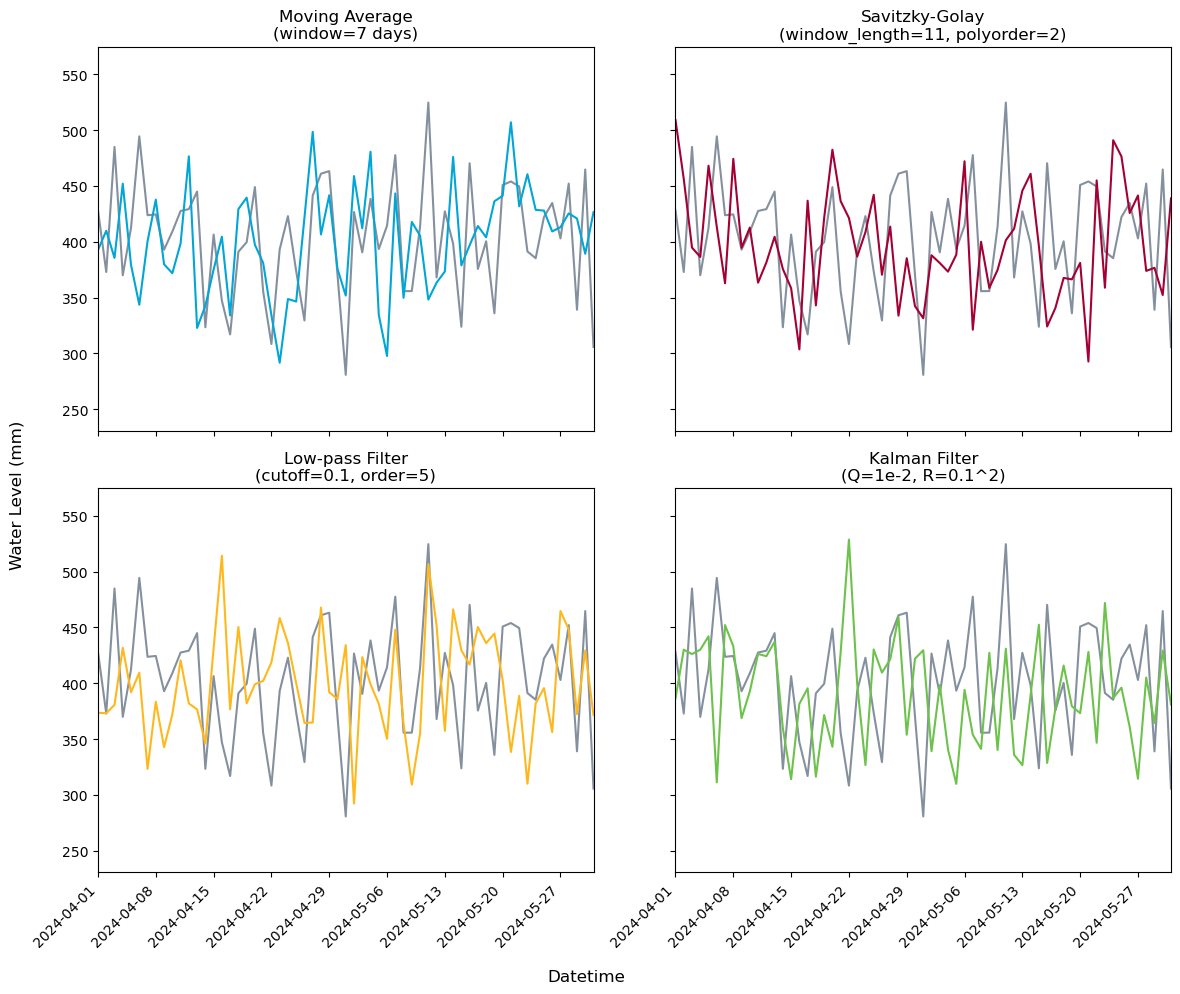

In [8]:
# Dummy data for illustration
dates = pd.date_range(start='2024-04-01', end='2024-05-31')
water_level = np.random.normal(400, 50, len(dates))
WL = pd.DataFrame({'Water_level_diver(mm)': water_level}, index=dates)

# Dummy filtered data for illustration
moving_average = np.random.normal(400, 50, len(dates))
savgol_filtered = np.random.normal(400, 50, len(dates))
lowpass_filtered = np.random.normal(400, 50, len(dates))
kalman_filtered = np.random.normal(400, 50, len(dates))

# Create subplots for individual filters
fig, axs = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Original dataset in each subplot
for ax in axs:
    ax.plot(WL.index, WL['Water_level_diver(mm)'], color='C1', label='Original Water Level', alpha=0.5)

# Plot each filter in a separate subplot with titles
axs[0].plot(WL.index, moving_average, color='C0')
axs[0].set_title('Moving Average\n(window=7 days)')

axs[1].plot(WL.index, savgol_filtered, color='C6')
axs[1].set_title('Savitzky-Golay\n(window_length=11, polyorder=2)')

axs[2].plot(WL.index, lowpass_filtered, color='C9')
axs[2].set_title('Low-pass Filter\n(cutoff=0.1, order=5)')

axs[3].plot(WL.index, kalman_filtered, color='C10')
axs[3].set_title('Kalman Filter\n(Q=1e-2, R=0.1^2)')

# Set x and y axis limits
for ax in axs:
    ax.set_xlim(WL.index.min(), WL.index.max())
    ax.set_ylim(WL['Water_level_diver(mm)'].min() - 50, WL['Water_level_diver(mm)'].max() + 50)
    ax.label_outer()  # Remove axis labels and ticks

# Add shared axis labels
fig.supxlabel('Datetime')
fig.supylabel('Water Level (mm)')

# Rotate date labels for better readability
plt.setp(axs, xticks=pd.date_range(start='2024-04-01', end='2024-05-31', freq='7D'))
plt.setp(axs, xticklabels=pd.date_range(start='2024-04-01', end='2024-05-31', freq='7D').strftime('%Y-%m-%d'))
for ax in axs:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')

# Tight layout to avoid overlap
plt.tight_layout()
plt.savefig('Figures/Filtered_Water_Level_Subplots.png')
plt.show()

## Simplifying Noise Reduction and Infiltration Capacity Analysis

While various sophisticated filters can be applied to reduce noise in the water level signal, such as Moving Average, Rolling Mean, Savitzky-Golay, Low-Pass, and Kalman Filters, they often overcomplicate the problem. These methods can introduce unnecessary complexity and may not provide a clear, intuitive understanding of the infiltration capacity.

To simplify the analysis and obtain a more straightforward measure of infiltration capacity, I chose to use a straight line from the maximum to the minimum of an infiltration event. This approach offers a clear visual representation and straightforward interpretation of the infiltration rate.

### Criteria for Identifying Infiltration Events:
- **No significant rainfall events (>10mm) interrupting the infiltration event.**
- **The event should last longer than two days.**
- **The infiltration rate should exceed 8 mm/day.**

These criteria ensure that the infiltration events are clearly defined and not influenced by external factors such as heavy rainfall. The events that meet these criteria are illustrated in the next figure with a red dashed line.


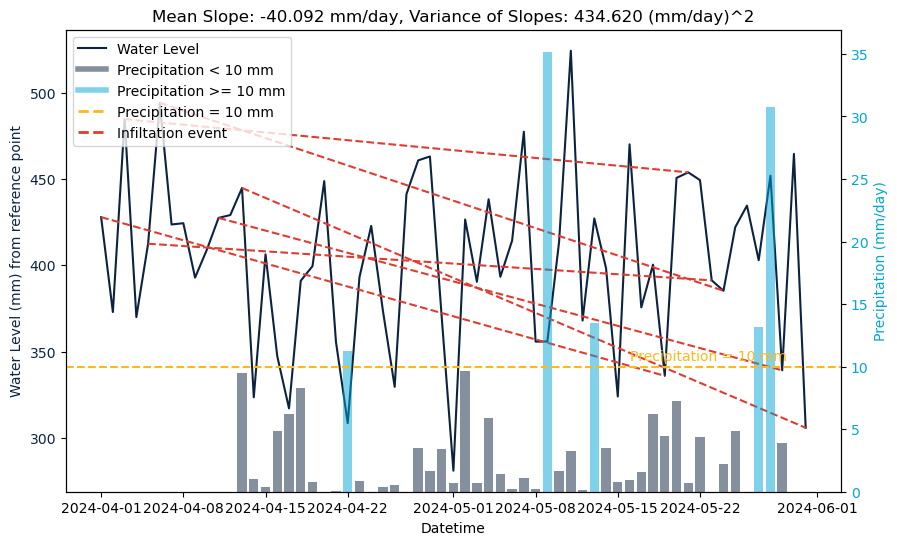

In [9]:
# Find all days with under 10 mm precipitation
under_10_precipitation_days = WS_daily_mean[WS_daily_mean['Daily Rain(mm)'] < 10]
over_10_precipitation_days = WS_daily_mean[WS_daily_mean['Daily Rain(mm)'] >= 10]

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Create a secondary y-axis for daily rain
ax2 = ax1.twinx()
bar_container_under_10 = ax2.bar(under_10_precipitation_days.index, under_10_precipitation_days['Daily Rain(mm)'], color='C1', alpha=0.5, label='Precipitation < 10 mm')
bar_container_over_10 = ax2.bar(over_10_precipitation_days.index, over_10_precipitation_days['Daily Rain(mm)'], color='C0', alpha=0.5, label='Precipitation >= 10 mm')
ax2.set_ylabel('Precipitation (mm/day)', color='C0')
ax2.tick_params(axis='y', labelcolor='C0')

# Plot water level
line1, = ax1.plot(WL.index, WL['Water_level_diver(mm)'], color='C1', label='Water Level')
ax1.set_ylabel('Water Level (mm) from reference point', color='C1')
ax1.tick_params(axis='y', labelcolor='C1')

# Add horizontal lines at y = 10
ax2.axhline(y=10, color='C9', linestyle='--')
ax2.text(WL.index[3*len(WL)//4], 10.5, 'Precipitation = 10 mm', color='C9')  # Adjusted position

# Add label for x-axis
ax1.set_xlabel('Datetime')

# Finding negative slopes in the water level plot
valid_slopes = []
rolling_window = 48  # 2 days with hourly data
slope_threshold_min = -8  # mm/day

for start in range(len(WL) - rolling_window):
    end = start + rolling_window
    slope = (WL['Water_level_diver(mm)'][end] - WL['Water_level_diver(mm)'][start]) / (rolling_window / 24)  # Convert to mm/day
    if slope <= slope_threshold_min:
        valid_slopes.append(slope)
        x1 = WL.index[start]
        y1 = WL['Water_level_diver(mm)'][start]
        x2 = WL.index[end]
        y2 = WL['Water_level_diver(mm)'][end]
        ax1.plot([x1, x2], [y1, y2], color='C7', linestyle='--')

# Calculate mean and variance of valid slopes
slopes_mean = np.mean(valid_slopes)
slopes_var = np.var(valid_slopes)

# Set title with mean and variance of slopes
ax1.set_title(f'Mean Slope: {slopes_mean:.3f} mm/day, Variance of Slopes: {slopes_var:.3f} (mm/day)^2')

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2 = [
    plt.Line2D([0], [0], color='C1', lw=4, alpha=0.5), 
    plt.Line2D([0], [0], color='C0', lw=4, alpha=0.5),
    plt.Line2D([0], [0], color='C9', linestyle='--', lw=2),
    plt.Line2D([0], [0], color='C7', linestyle='--', lw=2)
]
labels2 = ['Precipitation < 10 mm', 'Precipitation >= 10 mm', 'Precipitation = 10 mm', 'Infiltation event']

lines += lines2
labels += labels2

ax1.legend(lines, labels, loc='upper left')

# Save the plot without grid
plt.grid(False)
plt.savefig('Figures/BS_AdeKUS_2days.png')

# Show plot
plt.show()


These criteria ensure that the infiltration events are clearly defined and not influenced by external factors such as heavy rainfall. The events that meet these criteria are illustrated in the next figure, where the infiltration rate is mapped, differentiating faster infiltration events from slower ones and showing when each event occurred.


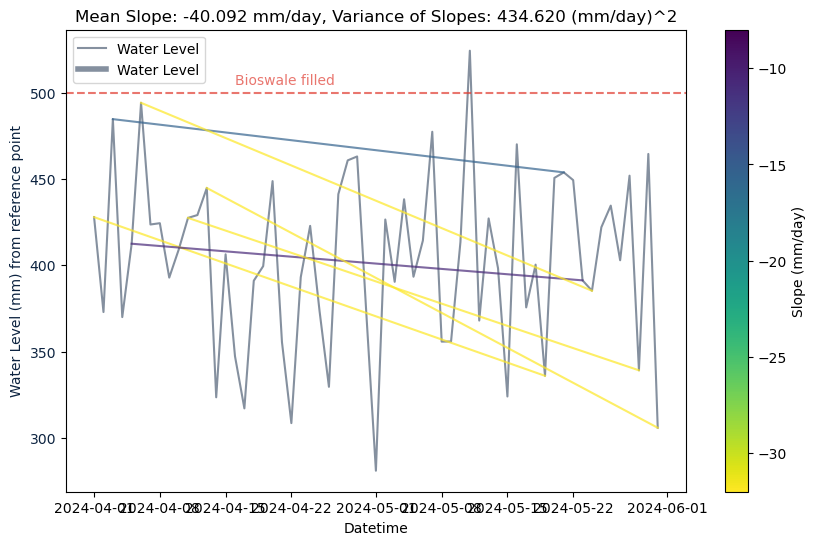

Highest negative slope: -69.605 mm/day over 48 days
with period: 2024-04-13 00:00:00 to 2024-05-31 00:00:00


In [10]:
# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot water level
line1, = ax1.plot(WL.index, WL['Water_level_diver(mm)'], color='C1', label='Water Level', alpha=0.5)
ax1.set_ylabel('Water Level (mm) from reference point', color='C1')
ax1.tick_params(axis='y', labelcolor='C1')

ax1.axhline(y=500, color='C7', linestyle='--', alpha=0.7)
ax1.text(WL.index[len(WL)//4], 505, 'Bioswale filled', color='C7', alpha=0.7)

# Add label for x-axis
ax1.set_xlabel('Datetime')

# Finding negative slopes in the water level plot
valid_slopes = []
rolling_window = 48  # 2 days with hourly data
slope_threshold_min = -8  # mm/day

norm = mcolors.Normalize(vmin=-32, vmax=slope_threshold_min)
cmap = plt.cm.viridis_r  # Reversed colormap to have brighter colors for higher negative slopes

# Variables to track the lowest slope
lowest_slope = np.inf
lowest_slope_start = None
lowest_slope_end = None

for start in range(len(WL) - rolling_window):
    end = start + rolling_window
    slope = (WL['Water_level_diver(mm)'][end] - WL['Water_level_diver(mm)'][start]) / (rolling_window / 24)  # Convert to mm/day
    if slope <= slope_threshold_min:
        valid_slopes.append(slope)
        if slope < lowest_slope:
            lowest_slope = slope
            lowest_slope_start = WL.index[start]
            lowest_slope_end = WL.index[end]
        x1 = WL.index[start]
        y1 = WL['Water_level_diver(mm)'][start]
        x2 = WL.index[end]
        y2 = WL['Water_level_diver(mm)'][end]
        color = cmap(norm(slope))
        ax1.plot([x1, x2], [y1, y2], color=color, alpha=.7)

# Calculate mean and variance of valid slopes
slopes_mean = np.mean(valid_slopes)
slopes_var = np.var(valid_slopes)

# Set title with mean and variance of slopes
ax1.set_title(f'Mean Slope: {slopes_mean:.3f} mm/day, Variance of Slopes: {slopes_var:.3f} (mm/day)^2')

# Add colorbar for slope values
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Only needed for matplotlib < 3.1
cbar = plt.colorbar(sm, ax=ax1)
cbar.set_label('Slope (mm/day)')

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2 = [plt.Line2D([0], [0], color='C1', lw=4, alpha=0.5)]
labels2 = ['Water Level']

lines += lines2
labels += labels2

ax1.legend(lines, labels, loc='upper left')

# Save the plot without grid
plt.grid(False)
plt.savefig('Figures/BS_AdeKUS_2days_colored.png')

# Show plot
plt.show()

# Print the lowest slope and the length of the slope in days
if lowest_slope_start and lowest_slope_end:
    lowest_slope_duration_days = (lowest_slope_end - lowest_slope_start).days
    print(f"Highest negative slope: {lowest_slope:.3f} mm/day over {lowest_slope_duration_days} days")
    print(f"with period: {lowest_slope_start} to {lowest_slope_end}")
else:
    print("No slopes found below the threshold.")

## Observations on Rainfall Events

The heaviest rainfall event occurred during the flood event of 13-5 to 15-5 at the bioswale, indicating that the surrounding area of the bioswale is used to infiltrate the water. In this test set-up, this is possible because the swale is surrounded by permeable soil. However, in other applications, bioswales are likely to be surrounded by impermeable soil such as asphalt and concrete. For that reason, the highest value during the flood event might not be reliable for determining the infiltration capacity of the bioswale.
This explanation should provide a clear rationale for your chosen method and 

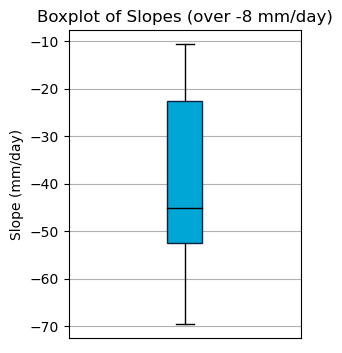

In [11]:
# Create a new figure for the boxplot
fig, ax_box = plt.subplots(figsize=(3, 4))  # Swap width and height to accommodate vertical orientation

# Plot boxplot of valid slopes with inverted axes
ax_box.boxplot(valid_slopes, vert=True, patch_artist=True, boxprops=dict(facecolor='C0', color='C1'), medianprops=dict(color='black'))
ax_box.set_ylabel('Slope (mm/day)')
ax_box.set_title('Boxplot of Slopes (over -8 mm/day)')

# Remove x-axis labels and ticks
ax_box.xaxis.set_visible(False)
ax_box.grid(True)

# Save plot
# plt.tight_layout()
plt.savefig('Figures/BS_AdeKUS_slope_boxplot.png')

# Show plot
plt.show()